In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
from utilities3 import *
from Adam import Adam
# 设备配置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Using device: cuda


In [2]:
# ------------------------------
# 1. 相对L2损失函数
# ------------------------------
def relative_l2_loss(pred, target):
    num_examples = pred.size()[0]
    diff_norms = torch.norm(pred.reshape(num_examples, -1) - target.reshape(num_examples, -1), 2, 1)
    target_norms = torch.norm(target.reshape(num_examples, -1), 2, 1)
    return torch.sum(diff_norms / (target_norms + 1e-8))  # 添加小常数防止除零



In [3]:
# ------------------------------
# 2. 数据预处理
# ------------------------------
def load_and_preprocess_data(data_path, n_train, n_test, sample_ratio=0.2):
    data = loadmat(data_path)
    u = data['u']  # (1500, 256, 100)
    x = data['x'].squeeze()  # (256,)
    t = data['t'].squeeze()  # (100,)

    # 分离实部和虚部
    u_real = torch.tensor(u.real, dtype=torch.float32)
    u_imag = torch.tensor(u.imag, dtype=torch.float32)

    # 初始条件 (t=0)
    train_u0 = torch.cat([u_real[:n_train, :, 0], u_imag[:n_train, :, 0]], dim=1)
    test_u0 = torch.cat([u_real[-n_test:, :, 0], u_imag[-n_test:, :, 0]], dim=1)

    # 生成所有 (x,t) 坐标 (t>0)
    xx, tt = np.meshgrid(x, t[1:], indexing='ij')
    all_coords = np.stack([xx.ravel(), tt.ravel()], axis=1)
    all_coords = torch.tensor(all_coords, dtype=torch.float32)

    # 随机采样训练点
    np.random.seed(42)
    num_points = int(len(all_coords) * sample_ratio)
    sampled_indices = np.random.choice(len(all_coords), num_points, replace=False)
    sampled_coords = all_coords[sampled_indices]

    # 训练目标
    train_target_real = u_real[:n_train, :, 1:].reshape(n_train, -1)[:, sampled_indices]
    train_target_imag = u_imag[:n_train, :, 1:].reshape(n_train, -1)[:, sampled_indices]
    train_target = torch.stack([train_target_real, train_target_imag], dim=-1)

    # 测试目标 (全网格)
    test_target = torch.stack([
        u_real[-n_test:, :, 1:].reshape(n_test, -1),
        u_imag[-n_test:, :, 1:].reshape(n_test, -1)
    ], dim=-1)

    # 归一化
#     def normalize(tensor):
#         return (tensor - tensor.mean()) / tensor.std()

#     train_u0 = normalize(train_u0)
#     test_u0 = normalize(test_u0)
#     train_target = normalize(train_target)
#     test_target = normalize(test_target)
#     all_coords = normalize(all_coords)
#     sampled_coords = normalize(sampled_coords)

    # 移动到设备
    train_u0 = train_u0.to(device)
    test_u0 = test_u0.to(device)
    sampled_coords = sampled_coords.to(device)
    train_target = train_target.to(device)
    all_coords = all_coords.to(device)
    test_target = test_target.to(device)

    return train_u0, test_u0, sampled_coords, train_target, all_coords, test_target, x, t




In [4]:

# ------------------------------
# 3. 模型定义
# ------------------------------
class DeepONet2D(nn.Module):
    def __init__(self, branch_input_dim=512, trunk_input_dim=2, hidden_dim=256, p=128):
        super().__init__()
        self.branch = nn.Sequential(
            nn.Linear(branch_input_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, p)
        )
        self.trunk = nn.Sequential(
            nn.Linear(trunk_input_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, p)
        )
        self.fc_out = nn.Sequential(
            nn.Linear(p, p),
            nn.GELU(),
            nn.Linear(p, 2)
        )

    def forward(self, u0, coords):
        b = self.branch(u0)
        t = self.trunk(coords)
        features = b.unsqueeze(1) * t
        return self.fc_out(features)



In [5]:
# ------------------------------
# 4. 训练和评估
# ------------------------------
def train(model, train_loader, optimizer, epoch, n_train):
    model.train()
    total_loss = 0.0
    for batch_idx, (u0, coords, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(u0, coords)
        loss = relative_l2_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()


    avg_loss = total_loss / n_train
    return avg_loss


def evaluate(model, test_loader, n_test=200 ):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for u0, coords, target in test_loader:
            output = model(u0, coords)
            loss = relative_l2_loss(output, target)
            total_loss += loss.item()
    avg_loss = total_loss / n_test
    return avg_loss





In [6]:
n_train = 1000
n_test = 200
train_u0, test_u0, sampled_coords, train_target, all_coords, test_target, x, t = \
    load_and_preprocess_data("../Data/NLSG.mat", n_train, n_test, sample_ratio=0.2)

# 创建DataLoader
train_dataset = TensorDataset(
    train_u0,
    sampled_coords.unsqueeze(0).repeat(train_u0.size(0), 1, 1),
    train_target
)
test_dataset = TensorDataset(
    test_u0,
    all_coords.unsqueeze(0).repeat(test_u0.size(0), 1, 1),
    test_target
)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

# 初始化模型和优化器
model = DeepONet2D().to(device)
learning_rate = 0.001
scheduler_step = 100
scheduler_gamma = 0.5
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)
print(count_params(model))

346242


In [7]:


t1 = time.time()
# 训练循环
best_loss = float('inf')
train_l2 = []
test_l2 = []
for epoch in range(500):
    train_loss = train(model, train_loader, optimizer, epoch, n_train)
    val_loss = evaluate(model, test_loader, n_test)
    print(f"Epoch {epoch}, Avg Train Loss: {train_loss:.6f},Avg Test Loss: {val_loss:.6f}")
    scheduler.step()
    train_l2.append(train_loss)
    test_l2.append(val_loss)
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Saved best model at epoch {epoch}")

print(f"Total Time:{time.time() - t1:.6f}s")

Epoch 0, Avg Train Loss: 0.668361,Avg Test Loss: 0.489659
Saved best model at epoch 0
Epoch 1, Avg Train Loss: 0.369340,Avg Test Loss: 0.263523
Saved best model at epoch 1
Epoch 2, Avg Train Loss: 0.248289,Avg Test Loss: 0.213347
Saved best model at epoch 2
Epoch 3, Avg Train Loss: 0.195131,Avg Test Loss: 0.178184
Saved best model at epoch 3
Epoch 4, Avg Train Loss: 0.182197,Avg Test Loss: 0.154393
Saved best model at epoch 4
Epoch 5, Avg Train Loss: 0.136074,Avg Test Loss: 0.119186
Saved best model at epoch 5
Epoch 6, Avg Train Loss: 0.120159,Avg Test Loss: 0.130245
Epoch 7, Avg Train Loss: 0.114802,Avg Test Loss: 0.101229
Saved best model at epoch 7
Epoch 8, Avg Train Loss: 0.100604,Avg Test Loss: 0.119934
Epoch 9, Avg Train Loss: 0.099175,Avg Test Loss: 0.100272
Saved best model at epoch 9
Epoch 10, Avg Train Loss: 0.095407,Avg Test Loss: 0.096380
Saved best model at epoch 10
Epoch 11, Avg Train Loss: 0.091957,Avg Test Loss: 0.070835
Saved best model at epoch 11
Epoch 12, Avg Train 

Epoch 126, Avg Train Loss: 0.017959,Avg Test Loss: 0.016601
Epoch 127, Avg Train Loss: 0.018334,Avg Test Loss: 0.016585
Epoch 128, Avg Train Loss: 0.015012,Avg Test Loss: 0.019447
Epoch 129, Avg Train Loss: 0.016879,Avg Test Loss: 0.014203
Epoch 130, Avg Train Loss: 0.019185,Avg Test Loss: 0.018420
Epoch 131, Avg Train Loss: 0.018316,Avg Test Loss: 0.020360
Epoch 132, Avg Train Loss: 0.020773,Avg Test Loss: 0.019018
Epoch 133, Avg Train Loss: 0.019559,Avg Test Loss: 0.017547
Epoch 134, Avg Train Loss: 0.017649,Avg Test Loss: 0.017568
Epoch 135, Avg Train Loss: 0.017202,Avg Test Loss: 0.016593
Epoch 136, Avg Train Loss: 0.016332,Avg Test Loss: 0.018243
Epoch 137, Avg Train Loss: 0.017738,Avg Test Loss: 0.016389
Epoch 138, Avg Train Loss: 0.015406,Avg Test Loss: 0.019309
Epoch 139, Avg Train Loss: 0.018135,Avg Test Loss: 0.020819
Epoch 140, Avg Train Loss: 0.016127,Avg Test Loss: 0.017230
Epoch 141, Avg Train Loss: 0.019376,Avg Test Loss: 0.015002
Epoch 142, Avg Train Loss: 0.014638,Avg 

Epoch 261, Avg Train Loss: 0.008745,Avg Test Loss: 0.009117
Epoch 262, Avg Train Loss: 0.008685,Avg Test Loss: 0.009061
Epoch 263, Avg Train Loss: 0.007799,Avg Test Loss: 0.009954
Epoch 264, Avg Train Loss: 0.007768,Avg Test Loss: 0.009332
Epoch 265, Avg Train Loss: 0.007623,Avg Test Loss: 0.007653
Epoch 266, Avg Train Loss: 0.008588,Avg Test Loss: 0.014420
Epoch 267, Avg Train Loss: 0.009949,Avg Test Loss: 0.008617
Epoch 268, Avg Train Loss: 0.008476,Avg Test Loss: 0.007158
Epoch 269, Avg Train Loss: 0.007368,Avg Test Loss: 0.009537
Epoch 270, Avg Train Loss: 0.008888,Avg Test Loss: 0.009413
Epoch 271, Avg Train Loss: 0.008565,Avg Test Loss: 0.008632
Epoch 272, Avg Train Loss: 0.007842,Avg Test Loss: 0.008051
Epoch 273, Avg Train Loss: 0.007960,Avg Test Loss: 0.008172
Epoch 274, Avg Train Loss: 0.007999,Avg Test Loss: 0.008741
Epoch 275, Avg Train Loss: 0.007872,Avg Test Loss: 0.007383
Epoch 276, Avg Train Loss: 0.007222,Avg Test Loss: 0.006923
Epoch 277, Avg Train Loss: 0.007301,Avg 

Epoch 394, Avg Train Loss: 0.004204,Avg Test Loss: 0.007623
Epoch 395, Avg Train Loss: 0.005931,Avg Test Loss: 0.005722
Epoch 396, Avg Train Loss: 0.004841,Avg Test Loss: 0.005043
Epoch 397, Avg Train Loss: 0.004707,Avg Test Loss: 0.004944
Epoch 398, Avg Train Loss: 0.004718,Avg Test Loss: 0.004507
Epoch 399, Avg Train Loss: 0.004528,Avg Test Loss: 0.006460
Epoch 400, Avg Train Loss: 0.003558,Avg Test Loss: 0.003665
Saved best model at epoch 400
Epoch 401, Avg Train Loss: 0.003030,Avg Test Loss: 0.003414
Saved best model at epoch 401
Epoch 402, Avg Train Loss: 0.003045,Avg Test Loss: 0.003485
Epoch 403, Avg Train Loss: 0.002972,Avg Test Loss: 0.003108
Saved best model at epoch 403
Epoch 404, Avg Train Loss: 0.002627,Avg Test Loss: 0.003163
Epoch 405, Avg Train Loss: 0.002717,Avg Test Loss: 0.003336
Epoch 406, Avg Train Loss: 0.002994,Avg Test Loss: 0.003559
Epoch 407, Avg Train Loss: 0.003026,Avg Test Loss: 0.003210
Epoch 408, Avg Train Loss: 0.002905,Avg Test Loss: 0.003225
Epoch 409,

In [8]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

pred_deeponet = torch.zeros(test_target.shape)
pred_l2 = []
s_time = time.time()
with torch.no_grad():
    for i in range(test_u0.size(0)):
        u0_sample = test_u0[i].unsqueeze(0)
        coords_sample = all_coords.unsqueeze(0)
        output = model(u0_sample, coords_sample).squeeze(0)
        pred_deeponet[i] = output
        test_loss = relative_l2_loss(output.unsqueeze(0), test_target[i, :].unsqueeze(0))
        pred_l2.append(test_loss)
        print(f"第{i + 1}个样本, Test Loss: {test_loss.item():.6f}")

    print(f" Total Time: {time.time() - s_time:.6f}s")

第1个样本, Test Loss: 0.003502
第2个样本, Test Loss: 0.006862
第3个样本, Test Loss: 0.002847
第4个样本, Test Loss: 0.001446
第5个样本, Test Loss: 0.001934
第6个样本, Test Loss: 0.001250
第7个样本, Test Loss: 0.006514
第8个样本, Test Loss: 0.002698
第9个样本, Test Loss: 0.003307
第10个样本, Test Loss: 0.003276
第11个样本, Test Loss: 0.002833
第12个样本, Test Loss: 0.003224
第13个样本, Test Loss: 0.002886
第14个样本, Test Loss: 0.002636
第15个样本, Test Loss: 0.002594
第16个样本, Test Loss: 0.001219
第17个样本, Test Loss: 0.002344
第18个样本, Test Loss: 0.001436
第19个样本, Test Loss: 0.003855
第20个样本, Test Loss: 0.004270
第21个样本, Test Loss: 0.003875
第22个样本, Test Loss: 0.001242
第23个样本, Test Loss: 0.001587
第24个样本, Test Loss: 0.009060
第25个样本, Test Loss: 0.002850
第26个样本, Test Loss: 0.004796
第27个样本, Test Loss: 0.001723
第28个样本, Test Loss: 0.002557
第29个样本, Test Loss: 0.003177
第30个样本, Test Loss: 0.003285
第31个样本, Test Loss: 0.002543
第32个样本, Test Loss: 0.001554
第33个样本, Test Loss: 0.001311
第34个样本, Test Loss: 0.002951
第35个样本, Test Loss: 0.001476
第36个样本, Test Loss: 0.001254
第

In [9]:
output_reshaped =  pred_deeponet.reshape(n_test, 256, 99, 2)  # [样本, 空间点, 时间步, 实部/虚部]
test_target_reshaped = test_target.view(n_test,256, 99, 2)
print(output_reshaped.shape,test_target_reshaped.shape)

torch.Size([200, 256, 99, 2]) torch.Size([200, 256, 99, 2])


In [10]:
def to_numpy_safe(x):
    if torch.is_tensor(x):
        return x.detach().cpu().numpy()
    elif isinstance(x, list):
        return [to_numpy_safe(i) for i in x]
    elif isinstance(x, dict):
        return {k: to_numpy_safe(v) for k, v in x.items()}
    else:
        return x  # already CPU float or numpy

scipy.io.savemat('NLSG_Deeponet.mat', {
    'pred_deeponet': to_numpy_safe(output_reshaped),
    'TrainL_2_deeponet': to_numpy_safe(train_l2),
    'TestL_2_deeponet': to_numpy_safe(test_l2),
    'Pred_L2_deeponet': to_numpy_safe(pred_l2),
})

100


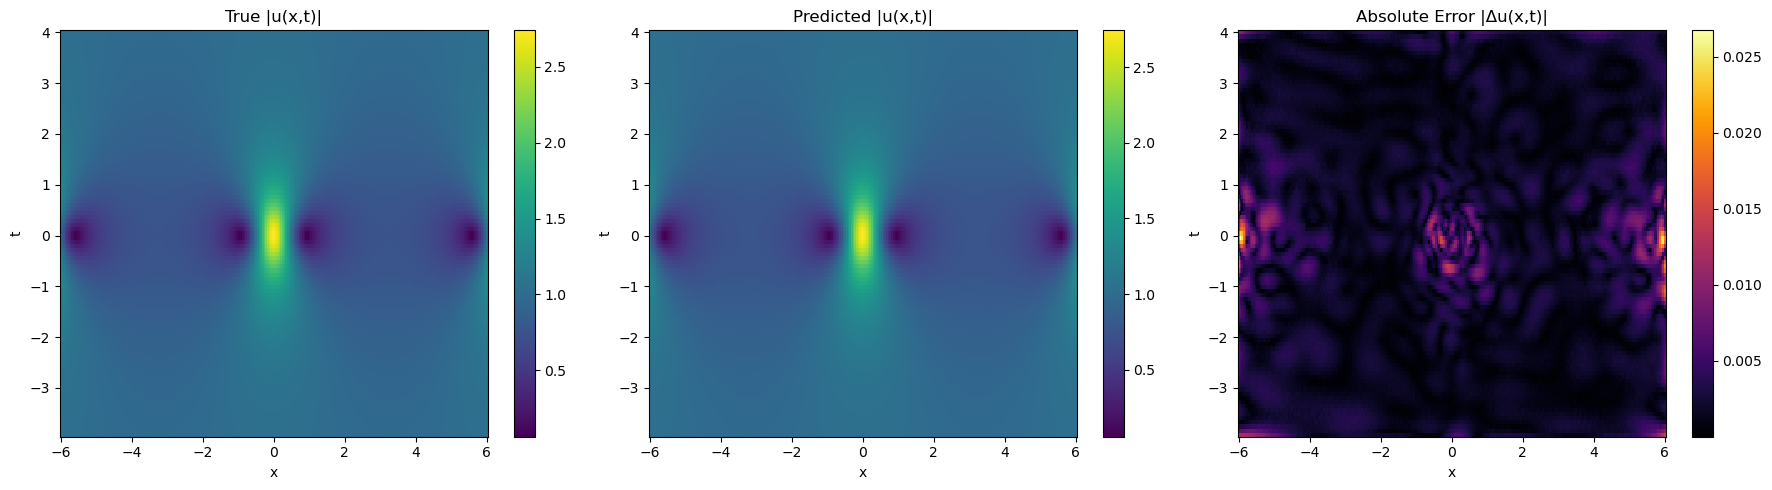

In [17]:
import matplotlib.pyplot as plt

# 随机选择一个样本
i = torch.randint(0, n_test, (1,)).item()
print(i)
# 获取实部和虚部
pred_real = output_reshaped[i, :, :, 0].cpu().numpy()
pred_imag = output_reshaped[i, :, :, 1].cpu().numpy()
true_real = test_target_reshaped[i, :, :, 0].cpu().numpy()
true_imag = test_target_reshaped[i, :, :, 1].cpu().numpy()

# 幅值和误差
pred_abs = np.sqrt(pred_real**2 + pred_imag**2)
true_abs = np.sqrt(true_real**2 + true_imag**2)
abs_error = np.sqrt((pred_real - true_real)**2 + (pred_imag - true_imag)**2)

# 网格坐标
x_grid, t_grid = np.meshgrid(x.squeeze(), t.squeeze()[1:], indexing='ij')  # (256, 99)

# 绘图
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

im0 = axs[0].pcolormesh(x_grid, t_grid, true_abs, shading='auto', cmap='viridis')
axs[0].set_title("True |u(x,t)|")
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].pcolormesh(x_grid, t_grid, pred_abs, shading='auto', cmap='viridis')
axs[1].set_title("Predicted |u(x,t)|")
plt.colorbar(im1, ax=axs[1])

im2 = axs[2].pcolormesh(x_grid, t_grid, abs_error, shading='auto', cmap='inferno')
axs[2].set_title("Absolute Error |Δu(x,t)|")
plt.colorbar(im2, ax=axs[2])

for ax in axs:
    ax.set_xlabel("x")
    ax.set_ylabel("t")

plt.tight_layout()
plt.show()
